In [39]:
import pandas as pd
import numpy as np
import requests

In [40]:
import os

In [41]:
os.getcwd()

'/Users/lphan/Documents/Spotify'

In [42]:
os.chdir('/Users/lphan/Documents/Spotify')

In [130]:
franklin = pd.read_json('endsong_0.json')
# df_stream1 = pd.read_json('streamingHistory1.json')

# merge streaming dataframes
# df_stream = pd.concat([df_stream0, df_stream1])

# # create a 'UniqueID' for each song by combining the fields 'artistName' and 'trackName'
# franklin['UniqueID'] = df_stream['artistName'] + ":" + df_stream['trackName']

# df_stream.describe()
franklin.to_csv('franklins.csv')

In [43]:
# read your 1+ StreamingHistory files (depending on how extensive your streaming history is) into pandas dataframes
df_stream0 = pd.read_json('StreamingHistory0.json')
df_stream1 = pd.read_json('streamingHistory1.json')

# merge streaming dataframes
df_stream = pd.concat([df_stream0, df_stream1])

# create a 'UniqueID' for each song by combining the fields 'artistName' and 'trackName'
df_stream['UniqueID'] = df_stream['artistName'] + ":" + df_stream['trackName']

df_stream.describe()

,msPlayed
count,2.000000e+04
mean,1.205404e+05
std,1.177225e+05
min,0.000000e+00
25%,5.920750e+03
50%,1.327020e+05
75%,2.083010e+05
max,8.254410e+06


In [12]:
df_stream.head()

,endTime,artistName,trackName,msPlayed,UniqueID
0,2022-02-15 13:58,Wanbi Tuan Anh,Vụt Mất,17142,Wanbi Tuan Anh:Vụt Mất
1,2022-02-16 15:49,Avril Lavigne,Sk8er Boi,900,Avril Lavigne:Sk8er Boi
2,2022-02-16 15:49,David Guetta,Like I Do,0,David Guetta:Like I Do
3,2022-02-16 15:52,Sia,The Greatest,850,Sia:The Greatest
4,2022-02-16 15:52,Astrid S,Hurts So Good,960,Astrid S:Hurts So Good


In [13]:
import json

# Open the original JSON file
with open('YourLibrary.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract the "tracks" dictionary from the data
tracks_dict = data['tracks']

# Save the "tracks" dictionary as a new JSON file
with open('YourLibrary1.json', 'w', encoding='utf-8') as f:
    json.dump(tracks_dict, f, ensure_ascii=False, indent=4)

# read your edited Library json file into a pandas dataframe
df_library = pd.read_json('YourLibrary1.json')


In [128]:
import json

# Open the original JSON file
with open('endsong_0.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract the "tracks" dictionary from the data
tracks_dict = data['spotify_track_uri']

# Save the "tracks" dictionary as a new JSON file
with open('endsong_0.json', 'w', encoding='utf-8') as f:
    json.dump(tracks_dict, f, ensure_ascii=False, indent=4)

# read your edited Library json file into a pandas dataframe
df_library = pd.read_json('endsong_0.json')


TypeError: list indices must be integers or slices, not str

In [14]:
# add UniqueID column (same as above)
df_library['UniqueID'] = df_library['artist'] + ":" + df_library['track']

# add column with track URI stripped of 'spotify:track:'
new = df_library["uri"].str.split(":", expand = True)
df_library['track_uri'] = new[2]

df_library.head()

,artist,album,track,uri,UniqueID,track_uri
0,EDEN,i think you think too much of me,XO,spotify:track:0ZAiqymvbQUZAh9y6ZT3Rm,EDEN:XO,0ZAiqymvbQUZAh9y6ZT3Rm
1,Lauv,The Other,The Other,spotify:track:3ZD3kjn80pQ9keYO8eqp9d,Lauv:The Other,3ZD3kjn80pQ9keYO8eqp9d
2,Belinda Carlisle,Greatest Vol.1 - Belinda Carlisle,Heaven Is a Place On Earth,spotify:track:37Q5anxoGWYdRsyeXkkNoI,Belinda Carlisle:Heaven Is a Place On Earth,37Q5anxoGWYdRsyeXkkNoI
3,Lauv,I met you when I was 18.,The Story Never Ends,spotify:track:3u5bTqHMM1P34ZkbwzdckV,Lauv:The Story Never Ends,3u5bTqHMM1P34ZkbwzdckV
4,Guns N' Roses,Use Your Illusion I,November Rain,spotify:track:3YRCqOhFifThpSRFJ1VWFM,Guns N' Roses:November Rain,3YRCqOhFifThpSRFJ1VWFM


In [15]:
# create final dict as a copy df_stream
combined_data = df_stream.copy()

# add column checking if streamed song is in library
# not used in this project but could be helpful for cool visualizations
combined_data['In Library'] = np.where(combined_data['UniqueID'].isin(df_library['UniqueID'].tolist()),1,0)

# left join with df_library on UniqueID to bring in album and track_uri
combined_data = pd.merge(combined_data, df_library[['album','UniqueID','track_uri']],how='left',on=['UniqueID'])

In [44]:
combined_data.sort_values('trackName')

,endTime,artistName,trackName,msPlayed,UniqueID,In Library,album,track_uri
13355,2022-10-28 01:54,Lex Fridman Podcast,"#185 – Sam Harris: Consciousness, Free Will, P...",406069,Lex Fridman Podcast:#185 – Sam Harris: Conscio...,0,NaN,NaN
13354,2022-10-28 00:44,Lex Fridman Podcast,"#185 – Sam Harris: Consciousness, Free Will, P...",8254410,Lex Fridman Podcast:#185 – Sam Harris: Conscio...,0,NaN,NaN
2933,2022-05-06 00:52,Flo D,#AiChoAi,36107,Flo D:#AiChoAi,0,NaN,NaN
3855,2022-05-17 18:51,015B,#tb,122700,015B:#tb,0,NaN,NaN
9469,2022-08-20 13:45,Anderson .Paak,'Til It's Over,85600,Anderson .Paak:'Til It's Over,0,NaN,NaN
...,...,...,...,...,...,...,...,...
9078,2022-08-15 20:48,S.H Project,"처음부터지금까지 From Beginning (From KBS Drama ""Winte...",3157,S.H Project:처음부터지금까지 From Beginning (From KBS ...,0,NaN,NaN
141,2022-02-16 21:02,2PM,하.니.뿐.,6540,2PM:하.니.뿐.,0,NaN,NaN
2332,2022-04-21 16:45,이경섭,허밍 셔플,12422,이경섭:허밍 셔플,0,NaN,NaN
12805,2022-10-17 00:54,Leessang,"헤어지지 못하는 여자, 떠나가지 못하는 남자 Can't Breakup Girl, C...",3274,"Leessang:헤어지지 못하는 여자, 떠나가지 못하는 남자 Can't Breaku...",0,NaN,NaN


In [118]:
# save your IDs from new project in Spotify Developer Dashboard
CLIENT_ID = '08923f56c32e46c1ae4b4ff05260b76f'
CLIENT_SECRET = '226fd5b07d874db0a61e720c750d646c'

In [119]:
# generate access token

# authentication URL
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

In [120]:
# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

# used for authenticating all API calls
headers = {'Authorization': 'Bearer {token}'.format(token=access_token)}

In [121]:
# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

In [122]:
# create blank dictionary to store track URI, artist URI, and genres
dict_genre = {}


In [123]:
# convert track_uri column to an iterable list
track_uris = df_library['track_uri'].to_list()


In [125]:
# loop through track URIs and pull artist URI using the API,
# then use artist URI to pull genres associated with that artist
# store all these in a dictionary
# generally took 5 minutes
for t_uri in track_uris:
      
    dict_genre[t_uri] = {'artist_uri': "", "genres":[]}
   
    r = requests.get(BASE_URL + 'tracks/' + t_uri, headers=headers)
    r = r.json()
    a_uri = r['artists'][0]['uri'].split(':')[2]
    dict_genre[t_uri]['artist_uri'] = a_uri
   
    s = requests.get(BASE_URL + 'artists/' + a_uri, headers=headers)
    s = s.json()
    dict_genre[t_uri]['genres'] = s['genres']

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [24]:
# convert dictionary into dataframe with track_uri as the first column
df_genre = pd.DataFrame.from_dict(dict_genre, orient='index')
df_genre.insert(0, 'track_uri', df_genre.index)
df_genre.reset_index(inplace=True, drop=True)

df_genre.head()

df_genre_expanded = df_genre.explode('genres')
df_genre_expanded.head()

,track_uri,artist_uri,genres
0,0ZAiqymvbQUZAh9y6ZT3Rm,1t20wYnTiAT0Bs7H1hv9Wt,indie poptimism
1,3ZD3kjn80pQ9keYO8eqp9d,5JZ7CnR6gTvEMKX4g70Amv,pop
2,37Q5anxoGWYdRsyeXkkNoI,7xkAwz0bQTGDSbkofyQt3U,new romantic
2,37Q5anxoGWYdRsyeXkkNoI,7xkAwz0bQTGDSbkofyQt3U,new wave pop
2,37Q5anxoGWYdRsyeXkkNoI,7xkAwz0bQTGDSbkofyQt3U,soft rock


In [50]:
combined_data2 = combined_data[combined_data['track_uri'].notna()]
combined_data2 = combined_data2.iloc[:, 1:].drop_duplicates()
# df_tableau2
top_tracks = combined_data2.sort_values('msPlayed', ascending=False).head(500)
top_tracks

,artistName,trackName,msPlayed,UniqueID,In Library,album,track_uri
15277,RAYE,Escapism. - Sped Up,667871,RAYE:Escapism. - Sped Up,1,Escapism.,4rPJSqrov3zqGwXlemLBMw
10576,Thùy Chi,Phiến Lá Tĩnh Lặng,548959,Thùy Chi:Phiến Lá Tĩnh Lặng,1,Phiến Lá Tĩnh Lặng,69EwGs863aPS8olgCWtZ8J
19661,DJ Khaled,"GOD DID (feat. Rick Ross, Lil Wayne, Jay-Z, Jo...",501648,"DJ Khaled:GOD DID (feat. Rick Ross, Lil Wayne,...",1,GOD DID,2sOj9vyd6yiss9W1IK6chU
1911,Ngô Anh Đạt,Cô Ấy Nói,469727,Ngô Anh Đạt:Cô Ấy Nói,1,Cô Ấy Nói,0F2gUQwJsy8iCfYv3uDgCp
15725,Travis Scott,3500 (feat. Future & 2 Chainz),461840,Travis Scott:3500 (feat. Future & 2 Chainz),1,Rodeo (Expanded Edition),1SGt65i9AnXYdDQt1AtDRH
...,...,...,...,...,...,...,...
11085,Gesaffelstein,Lost in the Fire (feat. The Weeknd),202093,Gesaffelstein:Lost in the Fire (feat. The Weeknd),1,Hyperion,2vXKRlJBXyOcvZYTdNeckS
191,SOOBIN,Đi Để Trở Về,202084,SOOBIN:Đi Để Trở Về,1,Đi Để Trở Về,5oDMahI0iti1HG9RBzzlHS
7439,MONSTAR,Badadu,201969,MONSTAR:Badadu,1,Badadu,4MdDjLdv6rLf53WltCDBhW
4914,Young T & Bugsey,Don't Rush (feat. DaBaby),201960,Young T & Bugsey:Don't Rush (feat. DaBaby),1,Don't Rush (feat. DaBaby),3AMxuq6id3YGB57eWeheZQ


In [96]:
# create blank dictionary to store audio features
feature_dict = {}

# convert track_uri column to an iterable list
track_uris = top_tracks['track_uri'].to_list()

# loop through track URIs and pull audio features using the API,
# store all these in a dictionary
for t_uri in track_uris:
    
    feature_dict[t_uri] = {'popularity': 0,
                           'danceability': 0,
                           'energy': 0,
                           'loudness':0,
                           'valence':0,
                           'acousticness':0,
                           'speechiness': 0,
                           'instrumentalness': 0,
                           'tempo': 0}
#     audio_features_list =['artist', 'album', 'track_name', 'track_id', 'danceability', 'energy', 'key', 'loudness', 'mode', 
#                               'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'acousticness']
    r = requests.get(BASE_URL + 'tracks/' + t_uri, headers=headers)
    r = r.json()
    feature_dict[t_uri]['popularity'] = r['popularity']
    
    s = requests.get(BASE_URL + 'audio-features/' + t_uri, headers=headers)
    s = s.json()
    feature_dict[t_uri]['danceability'] = s['danceability']
    feature_dict[t_uri]['energy'] = s['energy']
    feature_dict[t_uri]['loudness'] = s['loudness']
    feature_dict[t_uri]['valence'] = s['valence']
    feature_dict[t_uri]['acousticness'] = s['acousticness']
    feature_dict[t_uri]['speechiness'] = s['speechiness']
    feature_dict[t_uri]['instrumentalness'] = s['instrumentalness']
    feature_dict[t_uri]['tempo'] = s['tempo']

In [97]:
# convert dictionary into dataframe with track_uri as the first column
df_features = pd.DataFrame.from_dict(feature_dict, orient='index')
df_features.insert(0, 'track_uri', df_features.index)
df_features.reset_index(inplace=True, drop=True)

df_features.head()

,track_uri,popularity,danceability,energy,loudness,valence,acousticness,speechiness,instrumentalness,tempo
0,4rPJSqrov3zqGwXlemLBMw,77,0.435,0.768,-5.352,0.378,0.0857,0.2010,0.000231,107.588
1,69EwGs863aPS8olgCWtZ8J,41,0.632,0.349,-11.491,0.299,0.5970,0.0309,0.000000,148.009
2,2sOj9vyd6yiss9W1IK6chU,66,0.420,0.725,-4.262,0.186,0.0920,0.2230,0.000000,77.941
3,0F2gUQwJsy8iCfYv3uDgCp,0,0.600,0.326,-9.091,0.214,0.8430,0.0281,0.000000,84.996
4,1SGt65i9AnXYdDQt1AtDRH,67,0.773,0.595,-6.062,0.338,0.1140,0.1610,0.000002,123.968


In [98]:
df_features.to_csv("AudioFeaturesTable.csv")

### Create visualizations

In [ ]:
# list all the important files

In [57]:
# create vis for top artists in the last 3 months
combined_data

,endTime,artistName,trackName,msPlayed,UniqueID,In Library,album,track_uri
0,2022-02-15 13:58,Wanbi Tuan Anh,Vụt Mất,17142,Wanbi Tuan Anh:Vụt Mất,0,NaN,NaN
1,2022-02-16 15:49,Avril Lavigne,Sk8er Boi,900,Avril Lavigne:Sk8er Boi,1,Let Go,00Mb3DuaIH1kjrwOku9CGU
2,2022-02-16 15:49,David Guetta,Like I Do,0,David Guetta:Like I Do,1,Like I Do,6RnkFd8Fqqgk1Uni8RgqCQ
3,2022-02-16 15:52,Sia,The Greatest,850,Sia:The Greatest,1,This Is Acting (Deluxe Version),6bLopGnirdrilrpdVB6Um1
4,2022-02-16 15:52,Astrid S,Hurts So Good,960,Astrid S:Hurts So Good,1,Hurts So Good,3EVBx6WnnMj0qGpcPHjECA
...,...,...,...,...,...,...,...,...
19999,2023-02-12 19:25,Lady Gaga,Just Dance,2530,Lady Gaga:Just Dance,0,NaN,NaN
20000,2023-02-12 19:28,Shab,Dolce Vita,5997,Shab:Dolce Vita,0,NaN,NaN
20001,2023-02-12 19:28,Britney Spears,Toxic,198813,Britney Spears:Toxic,0,NaN,NaN
20002,2023-02-12 19:33,Black Eyed Peas,Boom Boom Pow,3134,Black Eyed Peas:Boom Boom Pow,0,NaN,NaN


In [58]:
combined_data['endTime']=pd.to_datetime(combined_data['endTime'])

In [59]:
import datetime 
max_date = combined_data['endTime'].max()
date_range = max_date - datetime.timedelta(days=90)

# filter the DataFrame based on the date range
recent_tracks = combined_data[combined_data['endTime'] >= date_range]
recent_tracks

,endTime,artistName,trackName,msPlayed,UniqueID,In Library,album,track_uri
14585,2022-11-15 02:07:00,Bill Charlap Trio,Day Dream,228058,Bill Charlap Trio:Day Dream,0,NaN,NaN
14586,2022-11-15 02:11:00,Herman Fred Trio,Small Steps,212363,Herman Fred Trio:Small Steps,0,NaN,NaN
14587,2022-11-15 02:15:00,Wildflower Trio,The Wind,237679,Wildflower Trio:The Wind,0,NaN,NaN
14588,2022-11-15 02:16:00,The Collective,All My Love,19806,The Collective:All My Love,0,NaN,NaN
14589,2022-11-15 02:16:00,Gene Hart Trio,Pensativa,80016,Gene Hart Trio:Pensativa,0,NaN,NaN
...,...,...,...,...,...,...,...,...
19999,2023-02-12 19:25:00,Lady Gaga,Just Dance,2530,Lady Gaga:Just Dance,0,NaN,NaN
20000,2023-02-12 19:28:00,Shab,Dolce Vita,5997,Shab:Dolce Vita,0,NaN,NaN
20001,2023-02-12 19:28:00,Britney Spears,Toxic,198813,Britney Spears:Toxic,0,NaN,NaN
20002,2023-02-12 19:33:00,Black Eyed Peas,Boom Boom Pow,3134,Black Eyed Peas:Boom Boom Pow,0,NaN,NaN


In [ ]:
track_list_ms = recent_tracks.groupby(['UniqueID'],as_index=False).sum('msPlayed').sort_values('msPlayed',ascending = False)
track_list_ms

,UniqueID,msPlayed,In Library
1467,RAYE:Escapism. - Sped Up,14366878,72
1149,Metro Boomin:Creepin' (with The Weeknd & 21 Sa...,9913718,56
1766,The Weeknd:Die For You,8877031,46
1654,Stacey Ryan:Fall In Love Alone - Sped Up Version,8360346,60
1975,ZICO:Any song,6886006,47
...,...,...,...
248,Bruno Major:Regent's Park,0,0
201,Big Sean:Bounce Back,0,1
187,Benson Boone:Before You,0,0
1936,Wren Evans:Trao,0,0


In [ ]:
track_list_ms = pd.merge(track_list_ms, recent_tracks[['artistName','trackName','album','UniqueID','track_uri']].drop_duplicates(),how='inner',on=['UniqueID'])

In [ ]:
track_list_ms['minutes'] = round(track_list_ms['msPlayed']/60000,1)
track_list_ms['hours'] = round(track_list_ms['minutes']/60,1)

In [ ]:
### most played songs
top_10_tracks = track_list_ms.head(10)
top_10_tracks[['trackName','artistName','msPlayed','minutes','hours']]

,trackName,artistName,msPlayed,minutes,hours
0,Escapism. - Sped Up,RAYE,14366878,239.4,4.0
1,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,9913718,165.2,2.8
2,Die For You,The Weeknd,8877031,148.0,2.5
3,Fall In Love Alone - Sped Up Version,Stacey Ryan,8360346,139.3,2.3
4,Any song,ZICO,6886006,114.8,1.9
5,Kill Bill,SZA,6807853,113.5,1.9
6,I Was Never There,The Weeknd,6545846,109.1,1.8
7,Collide (feat. Tyga),Justine Skye,6260562,104.3,1.7
8,Very Few Friends,Saint Levant,5626139,93.8,1.6
9,Đi Cùng Em,Hà Tròn,4893463,81.6,1.4


In [ ]:
##pip install wordcloud  
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud

In [ ]:
track_chart = px.bar(top_10_tracks.head(10), x='minutes', y='trackName', orientation='h', hover_data= ['artistName','hours'],
             labels={'num_plays': 'In Minutes', 'trackName': 'Song Name'})


In [ ]:

track_chart.update_layout(title={
        'text': "Your Top Recent Tracks",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font_size=16, 
                  xaxis_title='Total Minutes Played', yaxis_title='Song Name',
                  plot_bgcolor='rgb(255, 255, 255)', margin=dict(l=150, r=50, t=50, b=50))


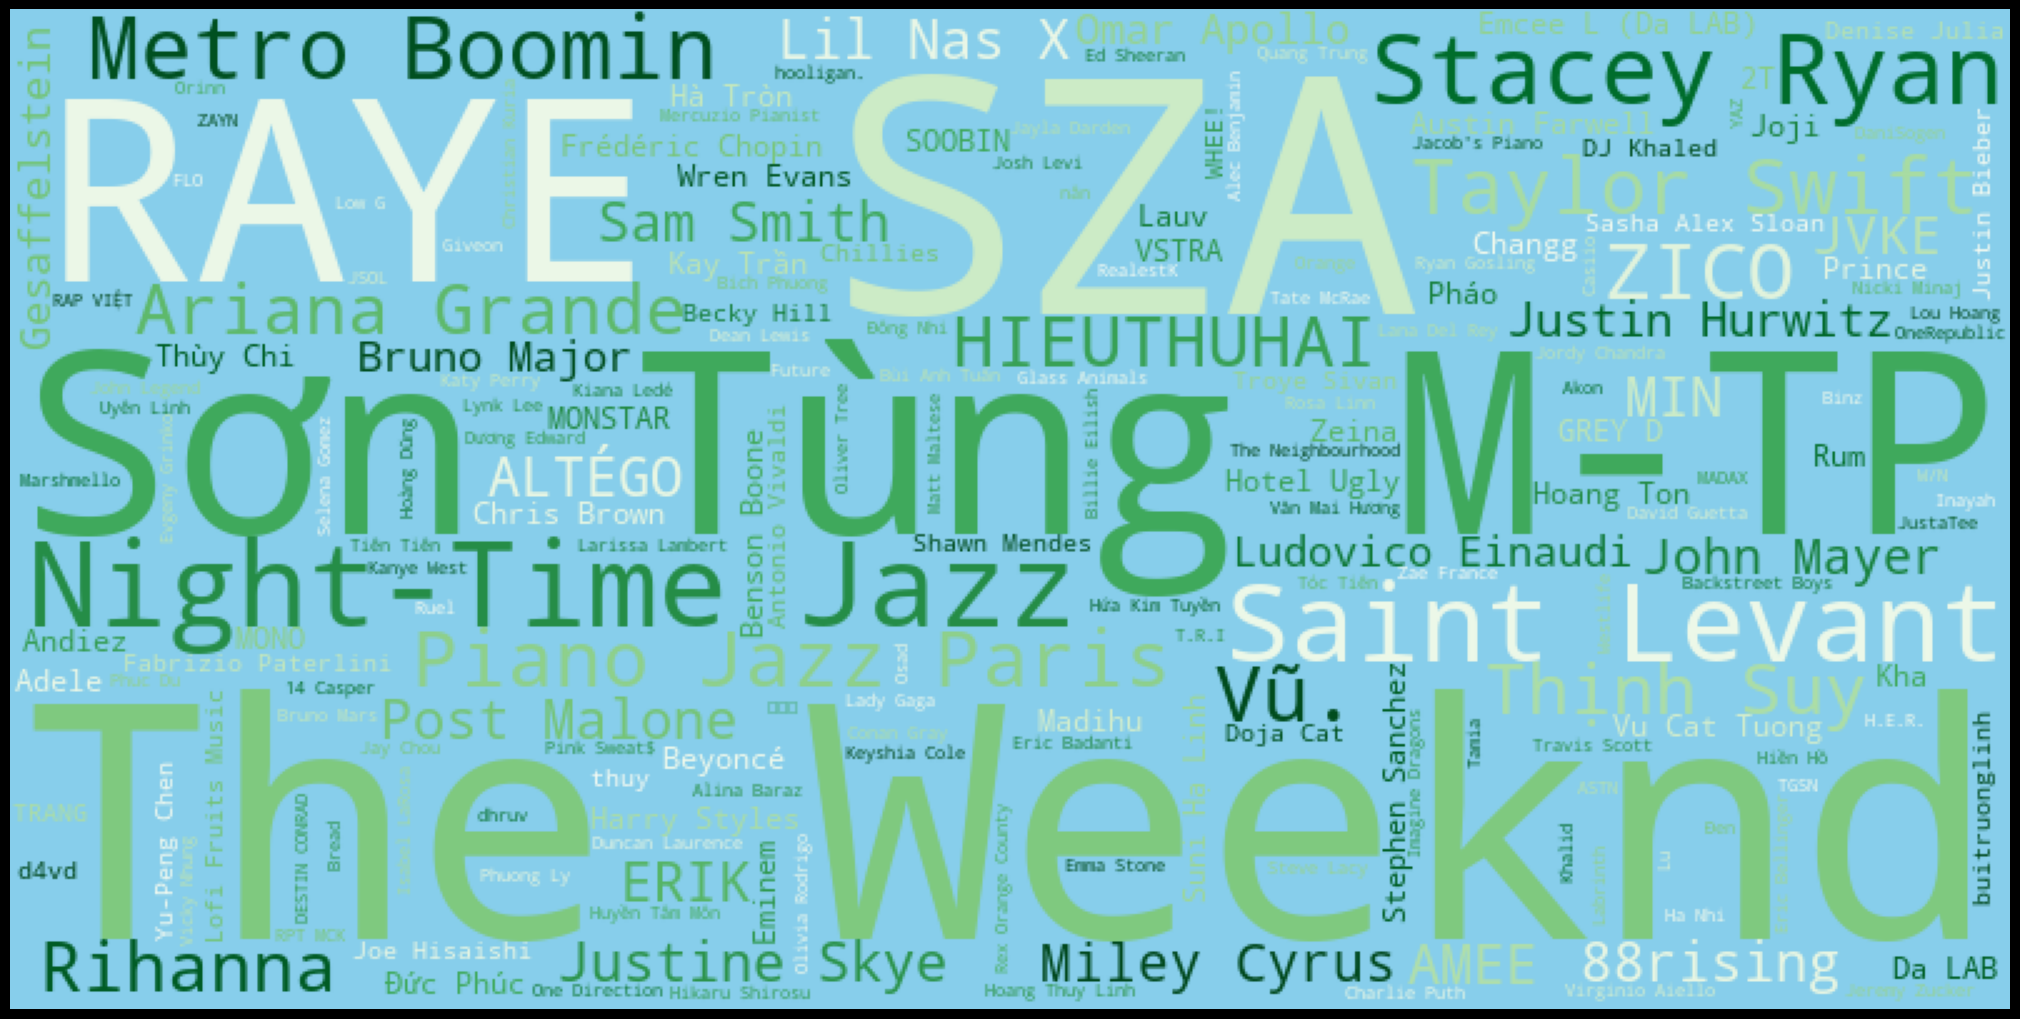

In [ ]:
### static chart
import matplotlib.pyplot as plt
# group the DataFrame by the 'fruit' column and count the number of occurrences of each fruit
freq = recent_tracks.groupby('artistName').size().reset_index(name='count')

# convert the 'freq' DataFrame to a dictionary to use as input to the WordCloud object
freq_dict = dict(zip(freq['artistName'], freq['count']))

# create a WordCloud object with relative scaling set to 0
wordcloud = WordCloud(width=800, height=400, relative_scaling=0,colormap='Greens',background_color="skyblue").generate_from_frequencies(freq_dict)
# Open a plot of the generated image.

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# group the DataFrame by the 'fruit' column and count the number of occurrences of each fruit
freq = recent_tracks.groupby('artistName').size().reset_index(name='count')

# convert the 'freq' DataFrame to a dictionary to use as input to the WordCloud object
freq_dict = dict(zip(freq['artistName'], freq['count']))

# create a WordCloud object with relative scaling set to 0
wordcloud = WordCloud(width=1000, height=500, relative_scaling=0,colormap='Greens',background_color="skyblue").generate_from_frequencies(freq_dict)
# convert the WordCloud object into an image that can be plotted in Plotly
img = wordcloud.to_image()

# create a Plotly figure and add the word cloud image to it
artist_chart = px.imshow(img)
artist_chart.update_layout(
    title={
        'text': "Your Top Recent Artists",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        font_size=16, 
    margin={'l': 0, 'r': 0, 'b': 0, 't': 50},
    xaxis=dict(visible=False),
    yaxis = dict(visible=False))

# show the Plotly figure
artist_chart.show()

### Need viz for genre

In [ ]:
top_genres = df_genre_expanded.groupby('genres').size().reset_index(name='count').sort_values('count',ascending=False)
top_genres.head(10)

,genres,count
228,pop,342
247,rap,206
310,v-pop,122
79,dance pop,106
132,hip hop,102
294,trap,100
233,pop rap,72
306,uk pop,61
179,melodic rap,56
50,canadian pop,53


In [ ]:
fig = px.bar(top_genres.head(10), x='genres', y='count')
fig.show()

In [ ]:
features_only = df_features[['danceability', 'energy', 'loudness','speechiness',
                             'valence', 'tempo', 'popularity']]

In [ ]:
#### need to normalize the audio features
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
music_feature = pd.DataFrame(scaler.fit_transform(features_only), columns=features_only.columns)

In [ ]:
import plotly.graph_objs as go


# Create radar chart
fig = go.Figure(data=go.Scatterpolar(
    r=list(round(music_feature.median(),2)),
    theta=['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Valence','Tempo','Popularity'],
    fill='toself'
))

# Update chart layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            # gridcolor="skyblue",
            visible=True,
            range=[0,1],
            tickfont=dict(color='slategrey')
        )),
    showlegend=False,
    title={'text': "Your Audio Features", 'x': 0.5, 'y': 0.95},
    margin=dict(l=0, r=0, t=60, b=0),
    font=dict(size=14)
)
# sandybrown, seagreen, seashell, sienna, silver,
#             skyblue, slateblue, slategray, slategrey, snow,
#             springgreen, steelblue, tan, teal, thistle, tomato,
#             turquoise, violet, wheat, white, whitesmoke,
#             yellow, yellowgreen
# Show chart
fig.show()

#change the website color
# from IPython.display import display, HTML
# display(HTML('<style>body{background-color: white;}</style>'))


In [100]:
# create blank dictionary to store audio features
feature_dict = {}

# convert track_uri column to an iterable list
track_uris = top_tracks['track_uri'].to_list()

# loop through track URIs and pull audio features using the API,
# store all these in a dictionary
for t_uri in track_uris:
    
    feature_dict[t_uri] = {'popularity': 0,
                           'danceability': 0,
                           'energy': 0,
                           'loudness':0,
                           'valence':0,
                           'acousticness':0,
                           'speechiness': 0,
                           'instrumentalness': 0,
                           'tempo': 0,
                           "genres":[]}
#     audio_features_list =['artist', 'album', 'track_name', 'track_id', 'danceability', 'energy', 'key', 'loudness', 'mode', 
#                               'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'acousticness']
    r = requests.get(BASE_URL + 'tracks/' + t_uri, headers=headers)
    r = r.json()
    feature_dict[t_uri]['popularity'] = r['popularity']
    
    s = requests.get(BASE_URL + 'audio-features/' + t_uri, headers=headers)
    s = s.json()
    feature_dict[t_uri]['danceability'] = s['danceability']
    feature_dict[t_uri]['energy'] = s['energy']
    feature_dict[t_uri]['loudness'] = s['loudness']
    feature_dict[t_uri]['valence'] = s['valence']
    feature_dict[t_uri]['acousticness'] = s['acousticness']
    feature_dict[t_uri]['speechiness'] = s['speechiness']
    feature_dict[t_uri]['instrumentalness'] = s['instrumentalness']
    feature_dict[t_uri]['tempo'] = s['tempo']

# loop through track URIs and pull artist URI using the API,
# then use artist URI to pull genres associated with that artist
# store all these in a dictionary
# generally took 5 minutes

    a_uri = r['artists'][0]['uri'].split(':')[2]
    feature_dict[t_uri]['artist_uri'] = a_uri
   
    g = requests.get(BASE_URL + 'artists/' + a_uri, headers=headers)
    g = g.json()
    feature_dict[t_uri]['genres'] = g['genres']
   

In [102]:
# convert dictionary into dataframe with track_uri as the first column
df_features_genres = pd.DataFrame.from_dict(feature_dict, orient='index')
df_features_genres.insert(0, 'track_uri', df_features_genres.index)
df_features_genres.reset_index(inplace=True, drop=True)

df_features_genres.head()

,track_uri,popularity,danceability,energy,loudness,valence,acousticness,speechiness,instrumentalness,tempo,genres,artist_uri
0,4rPJSqrov3zqGwXlemLBMw,77,0.435,0.768,-5.352,0.378,0.0857,0.2010,0.000231,107.588,"[uk contemporary r&b, uk pop]",5KKpBU5eC2tJDzf0wmlRp2
1,69EwGs863aPS8olgCWtZ8J,41,0.632,0.349,-11.491,0.299,0.5970,0.0309,0.000000,148.009,"[v-pop, vietnamese singer-songwriter]",0l3YAI1xmZKCZBzduST5ft
2,2sOj9vyd6yiss9W1IK6chU,66,0.420,0.725,-4.262,0.186,0.0920,0.2230,0.000000,77.941,"[hip hop, miami hip hop, pop rap, rap, trap]",0QHgL1lAIqAw0HtD7YldmP
3,0F2gUQwJsy8iCfYv3uDgCp,0,0.600,0.326,-9.091,0.214,0.8430,0.0281,0.000000,84.996,[viet lo-fi],15BdWDB7smcW5zPsl26u44
4,1SGt65i9AnXYdDQt1AtDRH,67,0.773,0.595,-6.062,0.338,0.1140,0.1610,0.000002,123.968,"[hip hop, rap, slap house]",0Y5tJX1MQlPlqiwlOH1tJY


In [103]:
df_features_genres

,track_uri,popularity,danceability,energy,loudness,valence,acousticness,speechiness,instrumentalness,tempo,genres,artist_uri
0,4rPJSqrov3zqGwXlemLBMw,77,0.435,0.768,-5.352,0.378,0.0857,0.2010,0.000231,107.588,"[uk contemporary r&b, uk pop]",5KKpBU5eC2tJDzf0wmlRp2
1,69EwGs863aPS8olgCWtZ8J,41,0.632,0.349,-11.491,0.299,0.5970,0.0309,0.000000,148.009,"[v-pop, vietnamese singer-songwriter]",0l3YAI1xmZKCZBzduST5ft
2,2sOj9vyd6yiss9W1IK6chU,66,0.420,0.725,-4.262,0.186,0.0920,0.2230,0.000000,77.941,"[hip hop, miami hip hop, pop rap, rap, trap]",0QHgL1lAIqAw0HtD7YldmP
3,0F2gUQwJsy8iCfYv3uDgCp,0,0.600,0.326,-9.091,0.214,0.8430,0.0281,0.000000,84.996,[viet lo-fi],15BdWDB7smcW5zPsl26u44
4,1SGt65i9AnXYdDQt1AtDRH,67,0.773,0.595,-6.062,0.338,0.1140,0.1610,0.000002,123.968,"[hip hop, rap, slap house]",0Y5tJX1MQlPlqiwlOH1tJY
...,...,...,...,...,...,...,...,...,...,...,...,...
332,4Ba99csVDlRFQILO5cSi7I,31,0.340,0.255,-13.713,0.460,0.8820,0.0611,0.000064,67.905,"[v-pop, vietnamese hip hop]",23xCr75lKvnFvKi8ImHE7S
333,3CRDbSIZ4r5MsZ0YwxuEkn,86,0.734,0.637,-5.677,0.648,0.0462,0.1410,0.000023,169.977,"[modern rock, pop, pov: indie, rock]",3YQKmKGau1PzlVlkL1iodx
334,5oDMahI0iti1HG9RBzzlHS,32,0.733,0.432,-9.624,0.673,0.4950,0.0292,0.000000,95.988,[v-pop],6CGGvCBHWqQ4HXtn5aLhbh
335,4MdDjLdv6rLf53WltCDBhW,32,0.803,0.835,-4.550,0.531,0.3180,0.0689,0.015100,98.987,[v-pop],2CLdtsyD2NsTOBBOVr7fi8


In [104]:
df_features_genres.to_csv('AudioFeaturesTableGenres.csv')

,artistName,trackName,msPlayed,UniqueID,In Library,album,track_uri
15277,RAYE,Escapism. - Sped Up,667871,RAYE:Escapism. - Sped Up,1,Escapism.,4rPJSqrov3zqGwXlemLBMw
19661,DJ Khaled,"GOD DID (feat. Rick Ross, Lil Wayne, Jay-Z, Jo...",501648,"DJ Khaled:GOD DID (feat. Rick Ross, Lil Wayne,...",1,GOD DID,2sOj9vyd6yiss9W1IK6chU
15725,Travis Scott,3500 (feat. Future & 2 Chainz),461840,Travis Scott:3500 (feat. Future & 2 Chainz),1,Rodeo (Expanded Edition),1SGt65i9AnXYdDQt1AtDRH
15078,SOOBIN,The Playah (feat. SlimV) - Special Performance,449577,SOOBIN:The Playah (feat. SlimV) - Special Perf...,1,The Playah (feat. SlimV),63qZf6349d3ngku9hrzLac
14928,SOOBIN,The Playah (feat. SlimV) - Special Performance,445809,SOOBIN:The Playah (feat. SlimV) - Special Perf...,1,The Playah (feat. SlimV),63qZf6349d3ngku9hrzLac
...,...,...,...,...,...,...,...
17861,HIEUTHUHAI,ngủ một mình,84263,HIEUTHUHAI:ngủ một mình,1,ngủ một mình,7opF2QJ8gzlxbV0eBIqszE
18581,HIEUTHUHAI,ngủ một mình,84149,HIEUTHUHAI:ngủ một mình,1,ngủ một mình,7opF2QJ8gzlxbV0eBIqszE
16971,The Weeknd,I Was Never There,83884,The Weeknd:I Was Never There,1,"My Dear Melancholy,",1cKHdTo9u0ZymJdPGSh6nq
17211,Madihu,Vì Anh Đâu Có Biết,83858,Madihu:Vì Anh Đâu Có Biết,1,Vì Anh Đâu Có Biết,6VXVYATpQXEIoZ97NnWCmn


In [85]:
df_features.to_csv('AudioFeaturesTable.csv')

In [105]:
mood = pd.read_csv('mood_data.csv')

In [106]:
moods = mood[~(mood['vibe'] == 'angry')]

In [107]:
moods

,Unnamed: 0,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,acousticness,popularity,album_release_date,vibe
0,0,Miley Cyrus,Flowers,Flowers,0yLdNVWF3Srea0uzk55zFn,0.707,0.681,0,-4.325,1,...,0.000005,0.0322,0.646,117.999,200455,4,0.06320,98.0,2023-01-13,upbeat
1,1,Rema,Calm Down (with Selena Gomez),Calm Down (with Selena Gomez),0WtM2NBVQNNJLh6scP13H8,0.801,0.806,11,-5.206,1,...,0.000669,0.1140,0.802,106.999,239318,4,0.38200,95.0,2022-08-25,upbeat
2,2,David Guetta,I'm Good (Blue),I'm Good (Blue),4uUG5RXrOk84mYEfFvj3cK,0.561,0.965,7,-3.673,0,...,0.000007,0.3710,0.304,128.040,175238,4,0.00383,94.0,2022-08-26,upbeat
3,3,Stephen Sanchez,Until I Found You (Em Beihold Version),Until I Found You (with Em Beihold) - Em Beiho...,1Y3LN4zO1Edc2EluIoSPJN,0.551,0.550,10,-5.339,1,...,0.000000,0.2020,0.342,101.190,176440,3,0.77700,93.0,2022-04-22,upbeat
4,4,OneRepublic,I Ain’t Worried (Music From The Motion Picture...,I Ain't Worried,4h9wh7iOZ0GGn8QVp4RAOB,0.704,0.797,0,-5.927,1,...,0.000745,0.0546,0.825,139.994,148486,4,0.08260,93.0,2022-05-13,upbeat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2774,2774,Joy Crookes,Don't Let Me Down (Demo),Don't Let Me Down - Demo,1VwPTHAfPvcL1ZubK6qabL,0.696,0.140,9,-11.509,1,...,0.000354,0.1480,0.203,80.831,195535,3,0.81800,54.0,2018-11-29,chill
2775,2775,Lee Fields & The Expressions,My World,Honey Dove,1emxi7e5EWFsJmwSKTuUDH,0.487,0.497,4,-5.776,0,...,0.167000,0.1090,0.195,160.317,246573,4,0.12400,53.0,2009-06-02,chill
2776,2776,Charlotte Day Wilson,ALPHA,Mountains,4JvEicQI7CxOJxuI0xtpim,0.540,0.399,10,-9.127,1,...,0.023900,0.3680,0.141,117.976,249334,4,0.77000,53.0,2021-07-09,chill
2777,2777,Raveena,Shanti,Love Child,7xlhCrF1qme2kFUmynnaQq,0.907,0.338,7,-10.944,1,...,0.032200,0.0418,0.848,95.989,163072,4,0.45400,53.0,2017-12-06,chill
